# Exploring global terror and using Bayes to understand differences in how populations experience it. 

### The Global Terrorism Database (GTD) is a collection of global terrorism compiled by many organizations with data dating from 1970 to 2016.  The University of Maryland decided to aggregate all this reporting in one place and that is the GTD. The team over there has instituted standardized forms of recording and coding terror events. According to the codebook data before 2011 suffers from the fact that it was compiled from many different source with a high variance in the definition of terrorism. Most concerning of all is we are missing all data from 1993 and other dates which we will attempt to impute later. 

# Problem Statement
### I will use Bayesian inference to look at an area of intreste in the data and I will also try to model the bombing for the missing year of 1993.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.style.use('fivethirtyeight')

% matplotlib inline
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
# import our eda libraries

In [2]:
df = pd.read_csv('/Users/natalie/Desktop/GA/project_5/globalterrorismdb_0617dist.csv')

/Users/natalie/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4,6,31,33,53,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [109]:
df.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,targtype2,targtype2_txt,targsubtype2,targsubtype2_txt,corp2,target2,natlty2,natlty2_txt,targtype3,targtype3_txt,targsubtype3,targsubtype3_txt,corp3,target3,natlty3,natlty3_txt,gname,gsubname,gname2,gsubname2,gname3,gsubname3,motive,guncertain1,guncertain2,guncertain3,individual,nperps,nperpcap,claimed,claimmode,claimmode_txt,claim2,claimmode2,claimmode2_txt,claim3,claimmode3,claimmode3_txt,compclaim,weaptype1,weaptype1_txt,weapsubtype1,weapsubtype1_txt,weaptype2,weaptype2_txt,weapsubtype2,weapsubtype2_txt,weaptype3,weaptype3_txt,weapsubtype3,weapsubtype3_txt,weaptype4,weaptype4_txt,weapsubtype4,weapsubtype4_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,Central America & Caribbean,NaN,Santo Domingo,18.456792,-69.951164,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,1,Assassination,NaN,NaN,NaN,NaN,14,Private Citizens & Property,68.0,Named Civilian,NaN,Julio Guzman,58.0,Dominican Republic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MANO-D,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,North America,NaN,Mexico city,19.432608,-99.133207,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,6,Hostage Taking (Kidnapping),NaN,NaN,NaN,NaN,7,Government (Diplomatic),45.0,"Diplomatic Personnel (outside of embassy, cons...",Belgian Ambassador Daughter,"Nadine Chaval, daughter",21.0,Belgium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23rd of September Communist League,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,NaN,Mexico,1.0,800000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,Southeast Asia,Tarlac,Unknown,15.478598,120.599741,4.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,1,Assassination,NaN,NaN,NaN,NaN,10,Journalists & Media,54.0,Radio Journalist/Staff/Facility,Voice of America,Employee,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,Western Europe,Attica,Athens,37.983773,23.728157,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,7,Government (Diplomatic),46.0,Embassy/Consulate,NaN,U.S. Embassy,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,Explosives/Bombs/Dynamite,16.0,Unknown Explosive Type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Explosive,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,

# EDA

### I wanted to run through some of the EDA decisions I made. So as stated above the data is a bit messy and has a lot of nan values and repetitive columns. So first I dropped NA with a threshold that losses any columns that had more than 1000 nan values. Then I looked a dates, and noticed we had thousand of observations either missing date or month. When I dug further I noticed a number of these also had the wrong year so I decided to drop all observation missing date or month data. I also observed an interesting trend when looking at monthly terror attacks, summers in the middle east are a hot time for terror.


In [56]:
def eda_helper(df):
    dict_list = []
    for col in df.columns:
        data = df[col]
        dict_ = {}
        # The null count for a column. Columns with no nulls are generally more interesting
        dict_.update({"null_count" : data.isnull().sum()})
        # Counting the unique values in a column
        # This is useful for seeing how interesting the column might be as a feature
        dict_.update({"unique_count" : len(data.unique())})
        # Finding the types of data in the column
        # This is useful for finding out potential problems with a column having strings and ints
        dict_.update({"data_type" : set([type(d).__name__ for d in data])})
        #dict_.update({"score" : match[1]})
        dict_list.append(dict_)
    eda_df = pd.DataFrame(dict_list)
    eda_df.index = df.columns
    #eda_df = eda_df.sort_values(['null_count','unique_count'], ascending=[True, False])
    return eda_df
# I plan to design my own eda fucntion but for now I am trying out a new one made by the talented Roland Jeannier

In [57]:
eda_helper(df)
# Nulls are an issue in this set which shouldnt be a surprise given the data and the descriptions in the code book

,data_type,null_count,unique_count
eventid,{int64},0,170350
iyear,{int64},0,46
imonth,{int64},0,13
iday,{int64},0,32
approxdate,"{float, str}",162886,1834
extended,{int64},0,2
resolution,"{float, str}",168131,1860
country,{int64},0,205
country_txt,{str},0,205
region,{int64},0,12


In [102]:
df.shape

(170350, 135)

In [4]:
df.dropna(thresh = 10000, axis = 1, inplace= True)
# This thresh argument drops all columns that have more than 1000 nul values

In [111]:
df.shape

(170350, 81)

In [5]:
df_date_check = df[(df['imonth'] == 0) | (df['iday'] == 0)]
# I want to look at the observation that have incorrect dates

In [79]:
df_date_check.head(200)

,eventid,iyear,imonth,iday,extended,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,targtype2,targtype2_txt,gname,motive,guncertain1,individual,nperps,nperpcap,claimed,claimmode,claimmode_txt,weaptype1,weaptype1_txt,weapsubtype1,weapsubtype1_txt,weaptype2,weaptype2_txt,weapsubtype2,weapsubtype2_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,ransom,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,datetime,imonth_fixed
1,197000000002,1970,0,0,0,130,Mexico,1,North America,NaN,Mexico city,19.432608,-99.133207,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,6,Hostage Taking (Kidnapping),7,Government (Diplomatic),45.0,"Diplomatic Personnel (outside of embassy, cons...",Belgian Ambassador Daughter,"Nadine Chaval, daughter",21.0,Belgium,NaN,NaN,23rd of September Communist League,NaN,0.0,0,7.0,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN,1969-11-30,01
2,197001000001,1970,1,0,0,160,Philippines,5,Southeast Asia,Tarlac,Unknown,15.478598,120.599741,4.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,1,Assassination,10,Journalists & Media,54.0,Radio Journalist/Staff/Facility,Voice of America,Employee,217.0,United States,NaN,NaN,Unknown,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,1969-12-31,01
3,197001000002,1970,1,0,0,78,Greece,8,Western Europe,Attica,Athens,37.983773,23.728157,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,3,Bombing/Explosion,7,Government (Diplomatic),46.0,Embassy/Consulate,NaN,U.S. Embassy,217.0,United States,NaN,NaN,Unknown,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,6,Explosives/Bombs/Dynamite,16.0,Unknown Explosive Type,NaN,NaN,NaN,NaN,Explosive,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,1969-12-31,01
4,197001000003,1970,1,0,0,101,Japan,4,East Asia,NaN,Fukouka,33.580412,130.396361,1.0,0,NaN,NaN,1,1,1,-9,NaN,NaN,0,1,0,7,Facility/Infrastructure Attack,7,Government (Diplomatic),46.0,Embassy/Consulate,NaN,U.S. Consulate,217.0,United States,NaN,NaN,Unknown,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,8,Incendiary,NaN,NaN,NaN,NaN,NaN,NaN,Incendiary,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,1969-12-31,01
96,197003000001,1970,3,0,0,160,Philippines,5,Southeast Asia,Metropolitian Manila,Manila,14.596051,120.978666,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,3,Bombing/Explosion,7,Government (Diplomatic),46.0,Embassy/Consulate,NaN,U.S. Embassy,217.0,United States,NaN,NaN,Unknown,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,6,Explosives/Bombs/Dynamite,16.0,Unknown Explosive Type,NaN,NaN,NaN,NaN,Explosive,0.0,NaN,NaN,0.0,NaN,NaN,1,3.0,Minor (likely < $1 million),500.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,1970-02-28,03
165,197004000001,1970,4,0,1,65,Ethiopia,11,Sub-Saharan Africa,Unknown,Unknown,NaN,NaN,5.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,6,Hostage Taking (Kidnapping),7,Government (Diplomatic),45.0,"Diplomatic Personnel (outside of embassy, cons...","Peace corps, U.S. government","Jack Fry, peace corps official",217.0,United States,NaN,NaN,Eritrean Liberation Front,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN,1970-03-31,04
244,197005000001,1970,5,0,0,217,United States,1,North America,Massachusetts,Boston,42.290156,-71.048970,1.0,0,Dorchester,5/0/1970: Unknown perpetrators set a fire at S...,1,1,1,1,2.0,Other Crime Type,0,1,0,7,Facility/Infrastructure Attack,15,Religious Figures/Institutions,8

In [80]:
df.iloc[1122]
# this is a bit concerning, this is one of 
# the observation that have incorrect date data, and it appears they also have the wrong year for this event.
#  becuase it wont be time effective to change all of these I will just drop all with missing dates and month data

eventid                             197200000002
iyear                                       1972
imonth                                         0
iday                                           0
extended                                       0
country                                      160
country_txt                          Philippines
region                                         5
region_txt                        Southeast Asia
provstate                                  Capiz
city                                       Roxas
latitude                                 11.5866
longitude                                122.754
specificity                                    1
vicinity                                       0
location                                     NaN
summary                                      NaN
crit1                                          1
crit2                                          1
crit3                                          1
doubtterr           

In [6]:
df.drop(df[(df.imonth == 0) | (df.iday == 0)].index, inplace=True)
# droping all entries with missing month and day info

In [7]:
def combine64(years, months=1, days=1, weeks=None, hours=None, minutes=None,
              seconds=None, milliseconds=None, microseconds=None, nanoseconds=None):
    years = np.asarray(years) - 1970
    months = np.asarray(months) - 1
    days = np.asarray(days) - 1
    types = ('<M8[Y]', '<m8[M]', '<m8[D]', '<m8[W]', '<m8[h]',
             '<m8[m]', '<m8[s]', '<m8[ms]', '<m8[us]', '<m8[ns]')
    vals = (years, months, days, weeks, hours, minutes, seconds,
            milliseconds, microseconds, nanoseconds)
    return sum(np.asarray(v, dtype=t) for t, v in zip(types, vals)
               if v is not None)
#  Joe shared this nice function for creating a datetime column which will come in handy for our tableaue viz

In [8]:
df['datetime']=combine64(df['iyear'], df['imonth'], df['iday'])
df['datetime']

0        1970-07-02
5        1970-01-01
6        1970-01-02
7        1970-01-02
8        1970-01-02
9        1970-01-03
10       1970-01-01
11       1970-01-06
12       1970-01-08
13       1970-01-09
14       1970-01-09
15       1970-01-10
16       1970-01-11
17       1970-01-12
18       1970-01-12
19       1970-01-13
20       1970-01-14
21       1970-01-15
22       1970-01-19
23       1970-01-19
24       1970-01-19
25       1970-01-20
26       1970-01-21
27       1970-01-22
28       1970-01-22
29       1970-01-25
30       1970-01-25
31       1970-01-26
32       1970-01-26
33       1970-01-27
34       1970-01-28
35       1970-01-28
36       1970-01-30
37       1970-01-30
38       1970-01-30
39       1970-01-31
40       1970-01-31
41       1970-02-01
42       1970-02-01
43       1970-02-02
44       1970-02-03
45       1970-02-03
46       1970-02-04
47       1970-02-06
48       1970-02-06
49       1970-02-06
50       1970-02-06
51       1970-02-06
52       1970-02-06
53       1970-02-06


In [125]:
df.head(15)

,eventid,iyear,imonth,iday,extended,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,targtype2,targtype2_txt,gname,motive,guncertain1,individual,nperps,nperpcap,claimed,claimmode,claimmode_txt,weaptype1,weaptype1_txt,weapsubtype1,weapsubtype1_txt,weaptype2,weaptype2_txt,weapsubtype2,weapsubtype2_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,ransom,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,datetime
0,197000000001,1970,7,2,0,58,Dominican Republic,2,Central America & Caribbean,NaN,Santo Domingo,18.456792,-69.951164,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,1,Assassination,14,Private Citizens & Property,68.0,Named Civilian,NaN,Julio Guzman,58.0,Dominican Republic,NaN,NaN,MANO-D,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN,1970-07-02
5,197001010002,1970,1,1,0,217,United States,1,North America,Illinois,Cairo,37.005105,-89.176269,1.0,0,NaN,1/1/1970: Unknown African American assailants ...,1,1,1,0,NaN,NaN,0,1,0,2,Armed Assault,3,Police,22.0,"Police Building (headquarters, station, school)",Cairo Police Department,Cairo Police Headquarters,217.0,United States,NaN,NaN,Black Nationalists,To protest the Cairo Illinois Police Deparment,0.0,0,-99.0,-99.0,0.0,NaN,NaN,5,Firearms,5.0,Unknown Gun Type,NaN,NaN,NaN,NaN,Several gunshots were fired.,0.0,0.0,0.0,0.0,0.0,0.0,1,3.0,Minor (likely < $1 million),NaN,NaN,0.0,NaN,NaN,0.0,"The Cairo Chief of Police, William Petersen, r...","""Police Chief Quits,"" Washington Post, January...","""Cairo Police Chief Quits; Decries Local 'Mili...","Christopher Hewitt, ""Political Violence and Te...",Hewitt Project,-9,-9,0,-9,NaN,1970-01-01
6,197001020001,1970,1,2,0,218,Uruguay,3,South America,Montevideo,Montevideo,-34.891151,-56.187214,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,0,0,1,Assassination,3,Police,25.0,Police Security Forces/Officers,Uruguayan Police,Juan Maria de Lucah/Chief of Directorate of in...,218.0,Uruguay,NaN,NaN,Tupamaros (Uruguay),NaN,0.0,0,3.0,NaN,NaN,NaN,NaN,5,Firearms,2.0,Automatic Weapon,NaN,NaN,NaN,NaN,Automatic firearm,0.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN,1970-01-02
7,197001020002,1970,1,2,0,217,United States,1,North America,California,Oakland,37.805065,-122.273024,1.0,0,Edes Substation,1/2/1970: Unknown perpetrators detonated explo...,1,1,1,1,2.0,Other Crime Type,0,1,0,3,Bombing/Explosion,21,Utilities,107.0,Electricity,Pacific Gas & Electric Company,Edes Substation,217.0,United States,NaN,NaN,Unknown,NaN,0.0,0,-99.0,-99.0,0.0,NaN,NaN,6,Explosives/Bombs/Dynamite,16.0,Unknown Explosive Type,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1,3.0,Minor (likely < $1 million),22500.0,Three transformers were damaged.,0.0,NaN,NaN,0.0,"Damages were estimated to be between $20,000-$...",Committee on Government Operations United Stat...,"Christopher Hewitt, ""Political Violence and Te...",NaN,Hewitt Project,-9,-9,0,-9,NaN,1970-01-02
8,197001020003,1970,1,2,0,217,United States,1,North America,Wisconsin,Madison,43.076592,-89.412488,1.0,0,NaN,"1/2/1970: Karl Armstrong, a member of the New ...",1,1,1,0,NaN,NaN,0,1,0,7,Facility/Infrastructure Attack,4,Military,28.0,Military Recruiting Station/Academy,R.O.T.C.,"R.O.T.C. offices at University of Wisconsin, M...",217.0,United States,NaN,NaN,New Year's Gang,To protest the War in Vietnam and the draft,0.0,0,1.0,1.0,1.0,1.0,Letter,8,Incendiary,19.0,Molotov Cocktail/Petrol Bomb,NaN,NaN,NaN,NaN,Firebomb consisting of gasoline,0.0,0.0,0.0,0.0,0.0,0.0,1,3.0,Minor (likely < $1 million),60000.0,"Basketball courts, weight roo

In [83]:
df['gname'].value_counts()
# I considered at look at diffrent groups but settled on examining attack success by region

Unknown                                                                                                             78306
Taliban                                                                                                              6575
Shining Path (SL)                                                                                                    4551
Islamic State of Iraq and the Levant (ISIL)                                                                          4287
Farabundo Marti National Liberation Front (FMLN)                                                                     3351
Al-Shabaab                                                                                                           2683
Irish Republican Army (IRA)                                                                                          2669
Revolutionary Armed Forces of Colombia (FARC)                                                                        2481
New People's Army (NPA) 

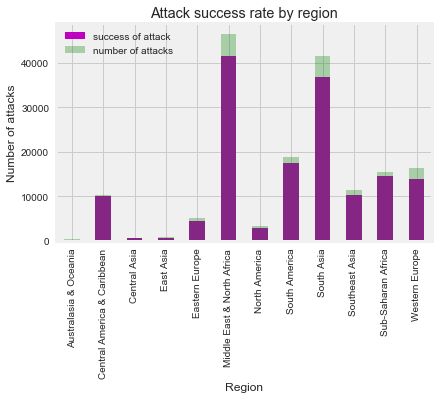

In [88]:
# we will look at succes rates, moving foward I will want to filter out unsuccessful attacks
df.groupby('region_txt').success.sum().plot(kind='bar', color='m', label='success of attack')
df.groupby('region_txt').eventid.count().plot(kind='bar', color='g', label='number of attacks', alpha=0.3)
plt.legend(loc='upper left')
plt.title("Attack success rate by region")
plt.ylabel("Number of attacks")
plt.xlabel("Region")
plt.figure(figsize=(100, 75))
#success is defined by tangible effects vs. whether the goal of the perpetrator was met

In [142]:
years = df.iyear.value_counts()

In [143]:
years = pd.DataFrame(years)
years.reset_index(inplace=True)


In [144]:
years.columns=['year','attacks']
# creating a data set of attacks by year for viz purposes

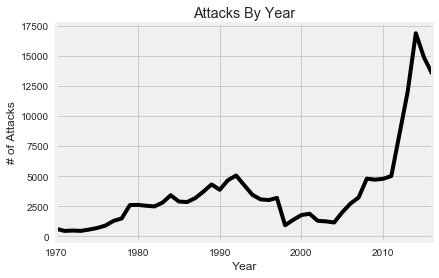

In [172]:
ax = sns.tsplot(years['attacks'], years['year'], color = 'black')
ax.set(title = 'Attacks By Year', xlabel='Year', ylabel='# of Attacks')
plt.figure(figsize=(100, 75))
#  attacks by year, large jump following shifting events in the middle east in 2010

In [147]:
months = df.imonth.value_counts()

In [148]:
months = pd.DataFrame(months)
months.reset_index(inplace=True)

In [149]:
months.columns=['month','attacks']

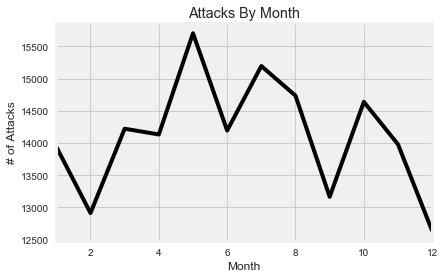

In [174]:
ax = sns.tsplot(months['attacks'], months['month'], color = 'black')
ax.set(title = 'Attacks By Month', xlabel='Month', ylabel='# of Attacks')
plt.figure(figsize=(100, 75))
# not too useful but interesting that attacks take place in the northern hemisphere's summer months

# Exporting bombing data for Tableau

In [182]:
df_bomb = df[df.weaptype1==6]

In [185]:
df_bomb.head()

,eventid,iyear,imonth,iday,extended,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,targtype2,targtype2_txt,gname,motive,guncertain1,individual,nperps,nperpcap,claimed,claimmode,claimmode_txt,weaptype1,weaptype1_txt,weapsubtype1,weapsubtype1_txt,weaptype2,weaptype2_txt,weapsubtype2,weapsubtype2_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,ransom,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,datetime
7,197001020002,1970,1,2,0,217,United States,1,North America,California,Oakland,37.805065,-122.273024,1.0,0,Edes Substation,1/2/1970: Unknown perpetrators detonated explo...,1,1,1,1,2.0,Other Crime Type,0,1,0,3,Bombing/Explosion,21,Utilities,107.0,Electricity,Pacific Gas & Electric Company,Edes Substation,217.0,United States,NaN,NaN,Unknown,NaN,0.0,0,-99.0,-99.0,0.0,NaN,NaN,6,Explosives/Bombs/Dynamite,16.0,Unknown Explosive Type,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1,3.0,Minor (likely < $1 million),22500.0,Three transformers were damaged.,0.0,NaN,NaN,0.0,"Damages were estimated to be between $20,000-$...",Committee on Government Operations United Stat...,"Christopher Hewitt, ""Political Violence and Te...",NaN,Hewitt Project,-9,-9,0,-9,NaN,1970-01-02
10,197001050001,1970,1,1,0,217,United States,1,North America,Wisconsin,Baraboo,43.468500,-89.744299,1.0,0,NaN,NaN,1,1,0,1,1.0,Insurgency/Guerilla Action,0,0,0,3,Bombing/Explosion,4,Military,27.0,Military Barracks/Base/Headquarters/Checkpost,NaN,Badger Army ammo depot.,217.0,United States,NaN,NaN,"Weather Underground, Weathermen",NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,6,Explosives/Bombs/Dynamite,16.0,Unknown Explosive Type,NaN,NaN,NaN,NaN,Explosive,0.0,NaN,NaN,0.0,NaN,NaN,0,3.0,Minor (likely < $1 million),0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN,1970-01-01
15,197001100001,1970,1,10,0,499,East Germany (GDR),9,Eastern Europe,NaN,East Berlin,52.516667,13.400000,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,3,Bombing/Explosion,2,Government (General),NaN,NaN,NaN,Jurists Ball (Palais au Frankturm),75.0,Germany,NaN,NaN,Commune 1,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,6,Explosives/Bombs/Dynamite,16.0,Unknown Explosive Type,NaN,NaN,NaN,NaN,Explosive,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,"Damages: none, attempted to detonate device an...",0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN,1970-01-10
17,197001120001,1970,1,12,0,217,United States,1,North America,New York,New York City,40.610069,-73.947971,1.0,0,Brooklyn,1/12/1970: Unknown perpetrators threw a pipe b...,1,1,1,0,NaN,NaN,0,1,0,3,Bombing/Explosion,8,Educational Institution,49.0,School/University/Educational Building,High School,James Madison High School,217.0,United States,NaN,NaN,Black Nationalists,Suspected motives were to protest the Vietnam ...,0.0,0,-99.0,-99.0,0.0,NaN,NaN,6,Explosives/Bombs/Dynamite,11.0,"Projectile (rockets, mortars, RPGs, etc.)",NaN,NaN,NaN,NaN,Crudely made pipe bomb. Five inches long and ...,0.0,0.0,0.0,0.0,0.0,0.0,1,3.0,Minor (likely < $1 million),NaN,Damaged a blackboard and shattered a pane of g...,0.0,NaN,NaN,0.0,"One half hour after the bomb explosion, an ano...","""Blast Damages Flatbush School,"" New York Time...","Linda Greenhouse, ""Madison School Puzzled By B...",Committee on Government Operations United Stat...,Hewitt Project,-9,-9,0,-9,NaN,1970-01-12
18,197001120002,1970,1,12,0,217,United States,1,North America,Puerto Rico,Rio Grande,18.379998,-65.830948,1.0,0,NaN,1/12/1970: Unknown perpetrators detonated a bo...,1,1,1,0,NaN,NaN,0,1,0,3,Bombing/Explosion,1,Business,4.0,Multinational Corporation,General Electric,General Electric factory in Rio Grande Puerto ...,217.0,United States,NaN,NaN,Strikers,NaN,0.0,0,-99.0,-9

In [189]:
df_bomb.to_csv('Tab_DF.csv')

# Bayesian Inference


### Having grappled with the data, it was time to find an interesting area in which to apply our Bayesian inference. This was a trial and error process, as I explored more than a few areas. 

### First, I tried to look at a handful of African countries, both pre- and post-coup, but that proved difficult as the time periods of stability were difficult to identify. Then I tried pre- and post-Cold War in Africa, which was also problematic. The post-2003 and post-2010 spikes in terror made it all the more challenging. 

### Finally, I settled on looking at two African nations, one that had the long standing, relatively stable regime, and one that did not, keeping all else as equal as possible. After some research I decided on Angola and Democratic Republic of Congo(DRC). My goal was to infer the relationship a regime, like the one in Angola, with one leader since independence, had to terrorism, in comparison with the DRC, a country which has had more names for their country than Angola has had leaders. By focusing on terror in these two countries we significantly shrank our data set making it perfect for Bayesian methods.
 
### Next, we had to establish a prior, I decided to use the rest of Africa. I wanted to compare the rate of terror in these two nations, not only against each other, but also against the trends in the region at large. So for a prior I picked the average attack by year for the full data set for all sub-Saharan African countries excluding Angola and DRC. 

### Having plotted my posteriors, the difference of means falls inside the credible parameter. So, my results seemed to show there wasn’t a statistically significant difference between the two, which left me a bit surprised. I decided to go back and do some additional EDA and research and I discovered why I didn’t get the results I expected. Angola has had the same leader for 36 years, however, what I didn’t realize was that for 20 years of that time he was fighting a civil war to stay in power. And if I had limited my analysis to post 2001 terror I might have observed the difference a stable regime can make. I plotted a few line graphs to display this.



In [217]:
df['region_txt'].unique()

array(['Central America & Caribbean', 'North America', 'South America',
       'Western Europe', 'Eastern Europe', 'Sub-Saharan Africa',
       'Southeast Asia', 'Middle East & North Africa', 'East Asia',
       'Australasia & Oceania', 'South Asia', 'Central Asia'], dtype=object)

In [26]:
df_S = df[df.success == 1]

In [ ]:
# so after some research I decided I wanted to look at 'stable' goverents in africa effect attack freq
# I tried to chose neigboring contries to try and cut down on outside factors and went with Angola and DRC in the end
#  angola has had one leader since independance where DRC has had more names for the nation thatn angola has had leaders

In [27]:
df_AF = df_S[df_S.region_txt == 'Sub-Saharan Africa']

In [28]:
df_AG = df_AF[df_AF.country_txt == 'Angola']

In [29]:
df_DRC = df_AF[df_AF.country_txt == 'Democratic Republic of the Congo']

In [30]:
df_AFprior = df_AF[(df_AF.country_txt != 'Angola') & (df_AF.country_txt != 'Democratic Republic of the Congo')]

In [31]:
df_AFprior.shape

(13388, 135)

In [32]:
df_DRC.shape

(588, 135)

In [33]:
df_AG.shape
# set up our data for bayes fun!

(480, 135)

In [47]:
#Relevant Libraries
import pymc3 as pm
import pydot

In [48]:
#Let's set up our populations
AF_AG = df_AG.iyear.value_counts().values
AF_DRC = df_DRC.iyear.value_counts().values

In [49]:
#Picking a prior, looking at all of sub-s africa minus AG and DRC
mean_prior_mean = df_AFprior.iyear.value_counts().mean()
mean_prior_std = df_AFprior.iyear.value_counts().std()

In [50]:
print mean_prior_mean
print mean_prior_std
#STD is large but given the number of countries and area some spread is to be expected

297.511111111
460.730429083


In [51]:
#INSTANTIATE MODEL
with pm.Model() as model:

    AG_mean = pm.Normal('attacks_AG_mean', mean_prior_mean, sd=mean_prior_std)
    DRC_mean = pm.Normal('attacks_DRC_mean', mean_prior_mean, sd=mean_prior_std)

In [52]:
std_prior_lower = 0.01
std_prior_upper = 100.0

with model:
    
    AG_std = pm.Uniform('attacks_AG_std', lower=std_prior_lower, upper=std_prior_upper)
    DRC_std = pm.Uniform('attacks_DRC_std', lower=std_prior_lower, upper=std_prior_upper)

In [89]:
with model:

    diff_of_means = pm.Deterministic('difference of means', AG_mean - DRC_mean)
    diff_of_stds = pm.Deterministic('difference of stds', AG_std - DRC_std)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((AG_std**2 + DRC_std**2) / 2))

ValueError: Variable name difference of means already exists.

In [55]:
with model:
    trace = pm.sample(20000, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 470.84:   6%|▌         | 11219/200000 [00:01<00:23, 8182.48it/s]
Convergence archived at 11500
Interrupted at 11,500 [5%]: Average Loss = 639.46
100%|██████████| 20500/20500 [03:08<00:00, 144.07it/s]
/Users/natalie/anaconda/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 3 does not match the target. It is 0.884481539513, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))


array([<matplotlib.axes._subplots.AxesSubplot object at 0x116582890>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11623e4d0>], dtype=object)

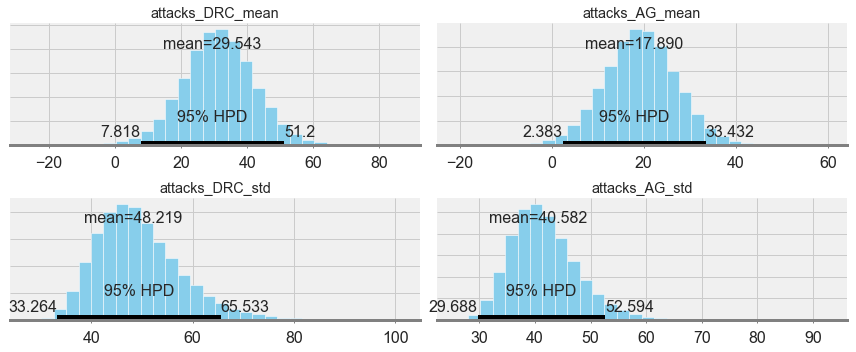

In [56]:
pm.plot_posterior(trace[3000:],
                  varnames=['attacks_DRC_mean', 'attacks_AG_mean', 'attacks_DRC_std', 'attacks_AG_std'],
                  color='#87ceeb')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x13d53d150>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x13d3badd0>], dtype=object)

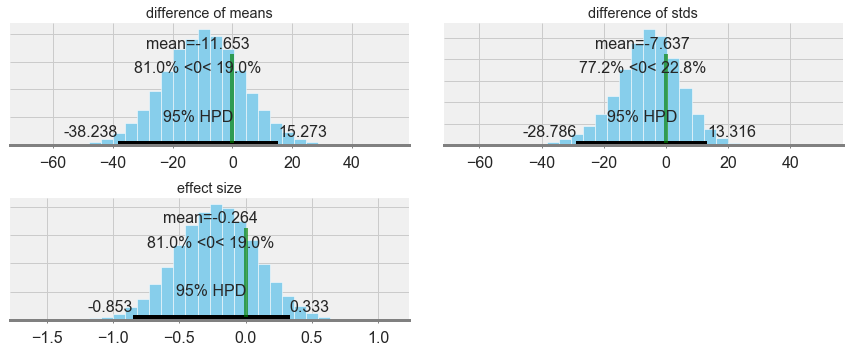

In [57]:
# there dosnt seem to be a great deal of diffrenece here, not sure if i did it wrong our maybe long serving leaders dont mean
#  there will be less terrorism 
pm.plot_posterior(trace[3000:],
                  varnames=['difference of means', 'difference of stds', 'effect size'],
                  ref_val=0,
                  color='#87ceeb')

In [64]:
pm.summary(trace[3000:],
           varnames=['difference of means', 'difference of stds', 'effect size'])



difference of means:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -11.653          13.573           0.080            [-38.238, 15.273]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -38.457        -20.645        -11.574        -2.718         15.129


difference of stds:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -7.637           10.565           0.051            [-28.786, 13.316]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -30.430        -13.925        -7.140         -0.670         11.940


effect size:

  Mean             SD               MC Error         95%

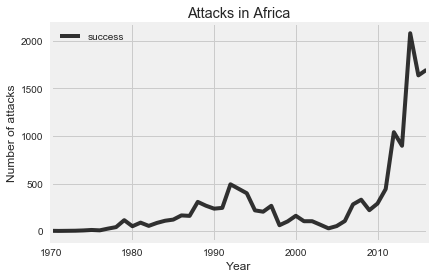

In [59]:
# Africa is consistant with the global rates
df_AFprior.groupby('iyear').success.sum().plot(kind="line", color='k', alpha=0.8)
plt.xlabel('Year')
plt.ylabel('Number of attacks')
plt.title('Attacks in Africa')

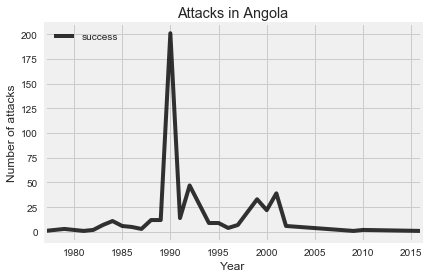

In [62]:
# here might be our diffence, perhaps the strong learship in Angola lead to 
# them avoiding the post 2010 jump the rest of the worl say

df_AG.groupby('iyear').success.sum().plot(kind="line", color='k', alpha=0.8)
plt.legend(loc='upper left')
plt.xlabel('Year')
plt.ylabel('Number of attacks')
plt.title('Attacks in Angola')

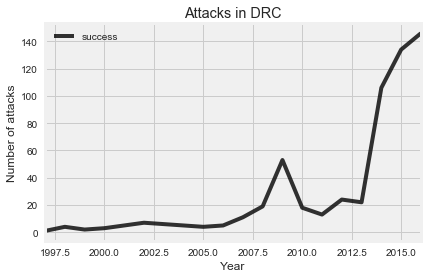

In [65]:


df_DRC.groupby('iyear').success.sum().plot(kind="line", color='k', alpha=0.8)
plt.legend(loc='upper left')
plt.xlabel('Year')
plt.ylabel('Number of attacks')
plt.title('Attacks in DRC')

# Predicting Bombings for the missing 1993 data

### To try and impute occurrences of bombing attacks in 1993, I used a rolling mean to determine values 1993, given the data for prior years as well as a few years following 1993. Limited my  data after 1993 to 2000 due to the uptick in terror following 9/11.

### Having looked at the correlation I settled on using 7 and 3 year lag.
### •	Looking at all years from 1970 - 2000
### •	Looking at a window of 7 years and 3 years.
### There did appear to be a little seasonality affecting the trend line, which I observed in my EDA, but there did appear to be randomly distributed errors through the dataset, which would have been difficult to control for given the inherent variability in terror attacks. The model also didn't come close approaching stationarity: the p-value was not statistically significant.
### This approach is not particularly complicated which is appealing but you might achieve better results by trying a few additional approaches.
### •	Account for the random spikes in certain years
### •	Approach stationarity using an ARIMA model
### With this approach, I took the rolling mean for my 7 year and 3 year lag, and then averaged them to arrive at my estimate of 1672 bombings in 1993. And if you look at the back of the codebook they have a estimated total attacks for 1993 and my number of 1672 tracks if you apply 1992 and 1994 bombing frequencies to that number per Tina’s findings.

In [69]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import datetime
from dateutil.relativedelta import relativedelta

import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import adfuller
# relevant libraries

/Users/natalie/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [70]:
df_b =df[df['attacktype1']==3]
# we made the csv for tab with a filter of wepone type but the assignment for the 1993 
# is to filter by bomb attack types

In [71]:
dfb_1993 = df_b[(df_b.iyear > 1970) & (df_b.iyear <= 2000)]
#  ok here we want to create our 1993 predictive data

In [72]:
X = dfb_1993['iyear'].value_counts().sort_index()


/Users/natalie/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).mean()
  after removing the cwd from sys.path.
/Users/natalie/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).std()
  """


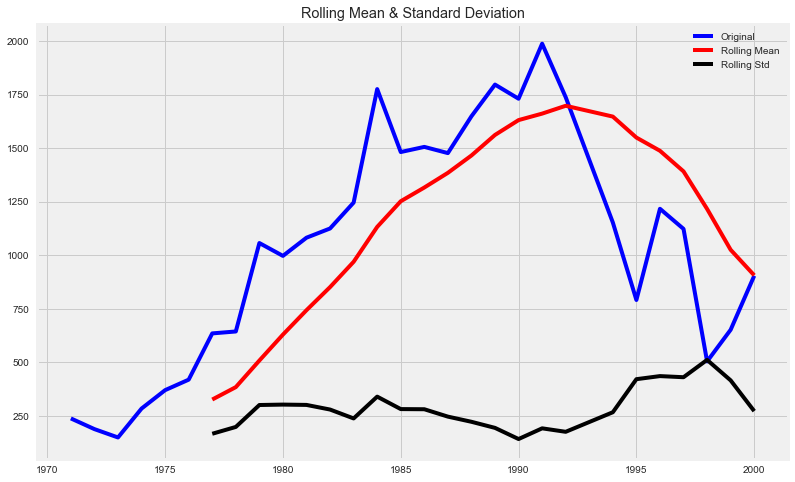

Results of Dickey-Fuller Test:
Test Statistic                 -2.552423
p-value                         0.103235
#Lags Used                      7.000000
Number of Observations Used    21.000000
Critical Value (5%)            -3.013098
Critical Value (1%)            -3.788386
Critical Value (10%)           -2.646397
dtype: float64


/Users/natalie/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:23: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).mean()


1971            NaN
1972            NaN
1973            NaN
1974            NaN
1975            NaN
1976            NaN
1977     326.142857
1978     384.142857
1979     508.285714
1980     629.428571
1981     743.428571
1982     851.285714
1983     969.428571
1984    1132.428571
1985    1252.142857
1986    1316.285714
1987    1384.857143
1988    1465.857143
1989    1561.857143
1990    1631.142857
1991    1661.428571
1992    1698.000000
1994    1647.571429
1995    1549.571429
1996    1487.857143
1997    1391.571429
1998    1216.285714
1999    1025.428571
2000     906.285714
Name: iyear, dtype: float64

In [73]:
def test_stationarity(timeseries, windownumber):
#  here we will pass our time series data our X and a window number which will
# specify our observation window using rolling mean
    rolmean = pd.rolling_mean(timeseries, window=windownumber)
    rolstd = pd.rolling_std(timeseries, window=windownumber)

    #Plot rolling stats:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput 
    return pd.rolling_mean(timeseries, window=windownumber)

# perform test
test_stationarity(X, 7)

/Users/natalie/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).mean()
  after removing the cwd from sys.path.
/Users/natalie/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).std()
  """


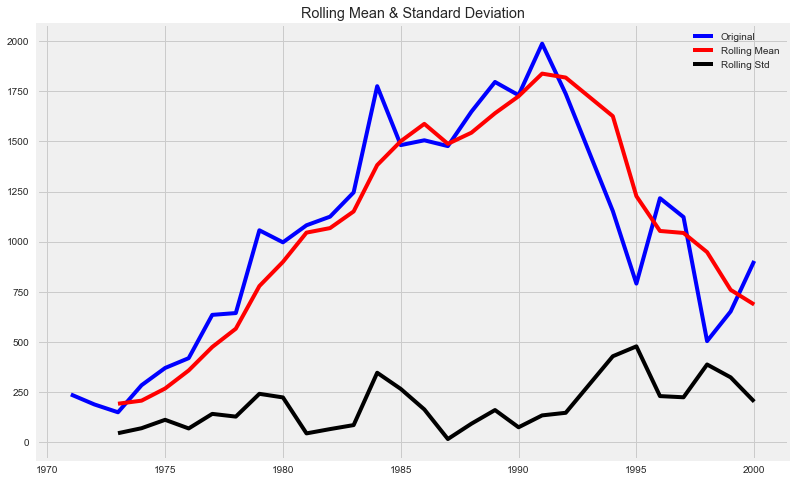

Results of Dickey-Fuller Test:
Test Statistic                 -2.552423
p-value                         0.103235
#Lags Used                      7.000000
Number of Observations Used    21.000000
Critical Value (5%)            -3.013098
Critical Value (1%)            -3.788386
Critical Value (10%)           -2.646397
dtype: float64


/Users/natalie/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:23: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).mean()


1971            NaN
1972            NaN
1973     191.666667
1974     207.000000
1975     267.666667
1976     357.666667
1977     474.666667
1978     566.000000
1979     778.666667
1980     899.333333
1981    1045.333333
1982    1068.000000
1983    1151.000000
1984    1382.333333
1985    1501.333333
1986    1588.000000
1987    1488.333333
1988    1544.000000
1989    1641.000000
1990    1725.666667
1991    1838.666667
1992    1819.000000
1994    1626.333333
1995    1227.333333
1996    1053.666667
1997    1043.666667
1998     948.000000
1999     759.666667
2000     686.666667
Name: iyear, dtype: float64

In [74]:
test_stationarity(X, 3)


In [75]:
##so lets determine 1994 by averaging 1992 and 1994's out put
print "1993 (with 7 day lag) likely saw around", (1698+1647.5714)/2,"bombings"
print "1993 (with 3 day lag) likely saw around", (1819+1626.33)/2,"bombings"

1993 (with 7 day lag) likely saw around 1672.7857 bombings
1993 (with 3 day lag) likely saw around 1722.665 bombings


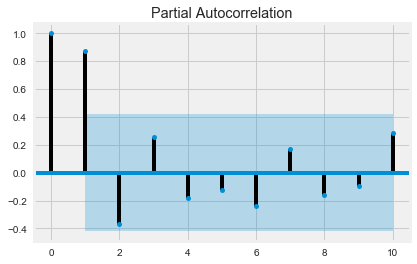

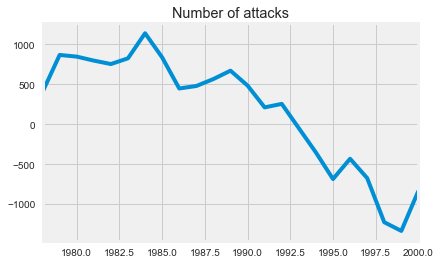

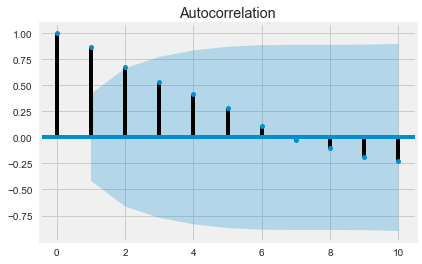

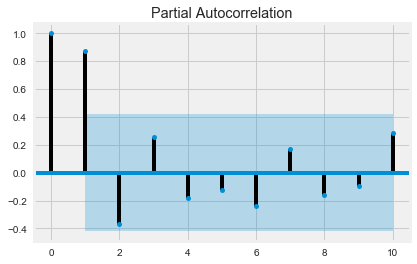

In [78]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Nnow we look at the autocorrelation

diff0 = X.diff(periods=7)[7:]
diff0.plot(title='Number of attacks')
plot_acf(diff0, lags=10)
plot_pacf(diff0, lags=10)

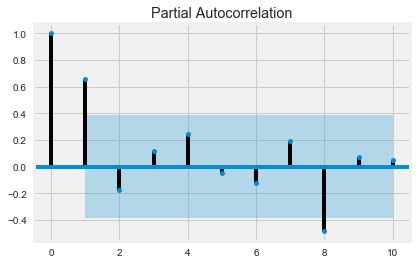

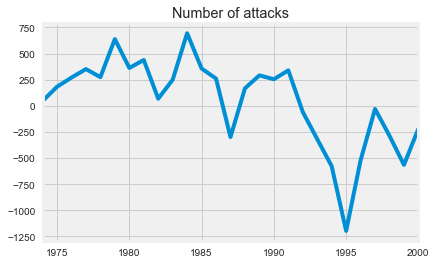

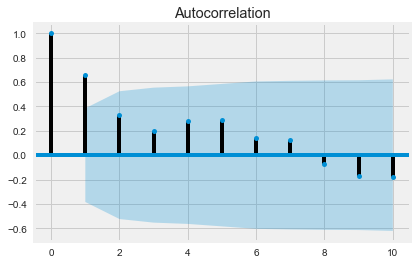

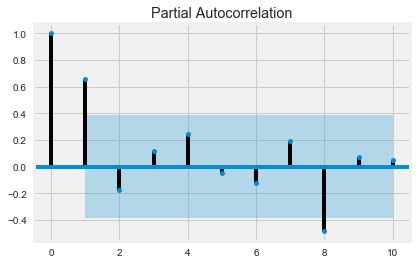

In [77]:
diff0 = X.diff(periods=3)[3:]
diff0.plot(title='Number of attacks')
plot_acf(diff0, lags=10)
plot_pacf(diff0, lags=10)